In [1]:
# Enable autoreload of local Python modules (e.g., models)
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import numpy as np
import jax
import jax.numpy as jnp
import optax
import time
import matplotlib.pyplot as plt

import models.models as models
import util.generation as generation


In [3]:
# ===================
# Experiment CONFIG
# ===================
CONFIG = dict(
    vocab_size = 27,
    d_model = 256,
    n_layers = 4,
    n_heads = 4,
    mlp_ratio = 4,
    dropout = 0.1,  # Dropout rate
    pos_encoding = "rope",  # "learned" or "sinusoidal" or "rope"
    tie_weights = True,
    max_len = 128,
    batch_size = 128,
    context_length = 128,
    learning_rate = 1e-3,
    lr_schedule = "cosine",  # or "cosine"
    optimizer = "adamw",  # or "adamw"
    grad_clip = 1.0,  # set > 0 for gradient clipping
    loss_on_last_token = False,  # True to only compute loss on last token
    label_smoothing = 0.1,  # 0.0 disables
    model_type = "transformer", # "transformer" or "lstm"
    niter = 100000,   # Short for demonstration; increase as needed
    print_every = 200,
    eval_every = 500,
    seed = 0,
)

# Set RNG
rng = jax.random.PRNGKey(CONFIG["seed"])

# Data loading and preprocessing

In [4]:
char_set = list("abcdefghijklmnopqrstuvwxyz ")
char_to_int = {ch: i for i, ch in enumerate(char_set)}
int_to_char = {i: ch for ch, i in char_to_int.items()}

def encode(s):
    return np.array([char_to_int[c] for c in s], dtype=np.uint8)

def decode(arr):
    return ''.join(int_to_char[int(i)] for i in arr)

with open("./data/text8_train.txt", "r") as f:
    train_text = f.read()
with open("./data/text8_test.txt", "r") as f:
    test_text = f.read()
print(f"Length of training text: {len(train_text):_} characters")
print(f"Length of test text: {len(test_text):_} characters")

train_text_int = encode(train_text)
test_text_int = encode(test_text)

def get_batch(text_int, B, T):
    ix = np.random.randint(0, len(text_int) - T, size=B)
    x = np.stack([text_int[i:i+T] for i in ix])
    y = np.stack([text_int[i+1:i+T+1] for i in ix])
    return jnp.array(x, dtype=jnp.int32), jnp.array(y, dtype=jnp.int32)

Length of training text: 90_000_000 characters
Length of test text: 5_000_000 characters


# Model initialization

In [5]:
# Select model type
if CONFIG["model_type"] == "transformer":
    model = models.DecoderOnlyTransformer(
        vocab_size=CONFIG["vocab_size"],
        d_model=CONFIG["d_model"],
        n_layers=CONFIG["n_layers"],
        n_heads=CONFIG["n_heads"],
        max_len=CONFIG["max_len"],
        mlp_ratio=CONFIG["mlp_ratio"],
        dropout=CONFIG["dropout"],
        pos_encoding=CONFIG["pos_encoding"],
        tie_weights=CONFIG["tie_weights"],
        deterministic=True,
    )
    dummy = jnp.zeros((1, min(CONFIG["context_length"], CONFIG["max_len"])), dtype=jnp.int32)
    params = model.init({"params": rng}, dummy)["params"]
else:
    raise ValueError("Only transformer is currently implemented in this notebook.")

def count_params(params):
    return sum(x.size for x in jax.tree_util.tree_leaves(params))
print(f"Number of parameters: {count_params(params):_}")

Number of parameters: 3_162_368


# Loss function and accuracy

In [6]:
def smoothed_cross_entropy(logits, targets, smoothing=0.1):
    n_classes = logits.shape[-1]
    on_value = 1.0 - smoothing
    off_value = smoothing / (n_classes - 1)
    targets_onehot = jax.nn.one_hot(targets, n_classes)
    smoothed_targets = targets_onehot * on_value + (1.0 - targets_onehot) * off_value
    return optax.softmax_cross_entropy(logits, smoothed_targets)

@jax.jit
def loss_and_metrics(logits, targets):
    vocab = logits.shape[-1]
    if CONFIG["loss_on_last_token"]:
        logits = logits[:, -1, :]
        targets = targets[:, -1]
        if CONFIG["label_smoothing"] > 0.0:
            per_pos = smoothed_cross_entropy(logits, targets, CONFIG["label_smoothing"])
        else:
            per_pos = optax.softmax_cross_entropy_with_integer_labels(logits, targets)
        loss = per_pos.mean()
        preds = jnp.argmax(logits, axis=-1)
        acc = jnp.mean((preds == targets).astype(jnp.float32))
        return loss, {"loss": loss, "acc": acc}
    else:
        flat_logits = logits.reshape(-1, vocab)
        flat_targets = targets.reshape(-1)
        if CONFIG["label_smoothing"] > 0.0:
            per_pos = smoothed_cross_entropy(flat_logits, flat_targets, CONFIG["label_smoothing"])
        else:
            per_pos = optax.softmax_cross_entropy_with_integer_labels(flat_logits, flat_targets)
        loss = per_pos.mean()
        preds = jnp.argmax(logits, axis=-1)
        is_match = preds == targets
        acc_all = jnp.mean(is_match.astype(jnp.float32))
        acc_last = jnp.mean(is_match.astype(jnp.float32)[:, -1])
        return loss, {"loss": loss, "acc": acc_all, "acc_last": acc_last}

# Optimizer and training step

In [7]:
def make_schedule(init_lr, warmup_steps, total_steps):
    warmup = optax.linear_schedule(init_value=0., end_value=init_lr, transition_steps=warmup_steps)
    decay = optax.cosine_decay_schedule(init_value=init_lr, decay_steps=max(1, total_steps-warmup_steps), alpha=0.01)
    # use warmup for first warmup_steps, then cosine
    def schedule(step):
        return jnp.where(step < warmup_steps, warmup(step), decay(step - warmup_steps))
    return schedule

In [8]:
# Learning rate schedule
if CONFIG["lr_schedule"] == "cosine":
    schedule = make_schedule(init_lr=CONFIG["learning_rate"], warmup_steps=1000, total_steps=CONFIG["niter"])
else:
    schedule = CONFIG["learning_rate"]

# Optimizer
if CONFIG["optimizer"] == "adamw":
    base_opt = optax.adamw(schedule)
else:
    base_opt = optax.adam(schedule)

# Gradient clipping
if CONFIG.get("grad_clip", 0.0) > 0.0:
    tx = optax.chain(optax.clip_by_global_norm(CONFIG["grad_clip"]), base_opt)
else:
    tx = base_opt
opt_state = tx.init(params)
print("Initialized optimizer.")

# Training step
@jax.jit
def train_step(params, opt_state, x, y):
    def loss_fn(params):
        logits = model.apply({"params": params}, x, deterministic=False)
        loss, metrics = loss_and_metrics(logits, y)
        return loss, metrics
    (loss, metrics), grads = jax.value_and_grad(loss_fn, has_aux=True)(params)
    updates, new_opt_state = tx.update(grads, opt_state, params)
    new_params = optax.apply_updates(params, updates)
    return new_params, new_opt_state, metrics

Initialized optimizer.


# Training loop

In [9]:
loss_history = []
acc_history = []
test_loss_history = []
test_acc_history = []
time_history = []

B, T = CONFIG["batch_size"], CONFIG["context_length"]
niter = CONFIG["niter"]
print_every = CONFIG["print_every"]
eval_every = CONFIG["eval_every"]
time_start = time.time()

for it in range(niter):
    x, y = get_batch(train_text_int, B, T)
    params, opt_state, metrics = train_step(params, opt_state, x, y)
    loss, acc = float(metrics['loss']), float(metrics['acc'])
    loss_history.append(loss)
    acc_history.append(acc)
    time_history.append(time.time() - time_start)

    if it % print_every == 0:
        print(f"Step {it:4d}: train loss={loss:.4f} acc={acc:.4f}")

    if it % eval_every == 0 or it == niter-1:
        # Evaluate on test batch
        test_x, test_y = get_batch(test_text_int, B, T)
        test_logits = model.apply({"params": params}, test_x, deterministic=True)
        test_loss, test_metrics = loss_and_metrics(test_logits, test_y)
        test_loss, test_acc = float(test_loss), float(test_metrics['acc'])
        test_loss_history.append(test_loss)
        test_acc_history.append(test_acc)
        print(f"  [Eval] test loss={test_loss:.4f} test acc={test_acc:.4f}")

Step    0: train loss=3.7773 acc=0.0142
  [Eval] test loss=3.7673 test acc=0.0167
Step  200: train loss=2.2502 acc=0.4033
Step  400: train loss=1.9845 acc=0.5013
  [Eval] test loss=1.9402 test acc=0.5180
Step  600: train loss=1.8687 acc=0.5405
Step  800: train loss=1.8300 acc=0.5500
Step 1000: train loss=1.8501 acc=0.5505
  [Eval] test loss=1.8081 test acc=0.5596
Step 1200: train loss=1.7789 acc=0.5701
Step 1400: train loss=1.7337 acc=0.5865
  [Eval] test loss=1.7367 test acc=0.5856
Step 1600: train loss=1.7169 acc=0.5883
Step 1800: train loss=1.7352 acc=0.5869
Step 2000: train loss=1.6921 acc=0.5990
  [Eval] test loss=1.7505 test acc=0.5790
Step 2200: train loss=1.6945 acc=0.5970
Step 2400: train loss=1.6831 acc=0.6002
  [Eval] test loss=1.7378 test acc=0.5801
Step 2600: train loss=1.6613 acc=0.6147
Step 2800: train loss=1.7072 acc=0.5961
Step 3000: train loss=1.6798 acc=0.6056
  [Eval] test loss=1.6975 test acc=0.5941
Step 3200: train loss=1.6830 acc=0.6055
Step 3400: train loss=1.67

# Plotting loss/accuracy

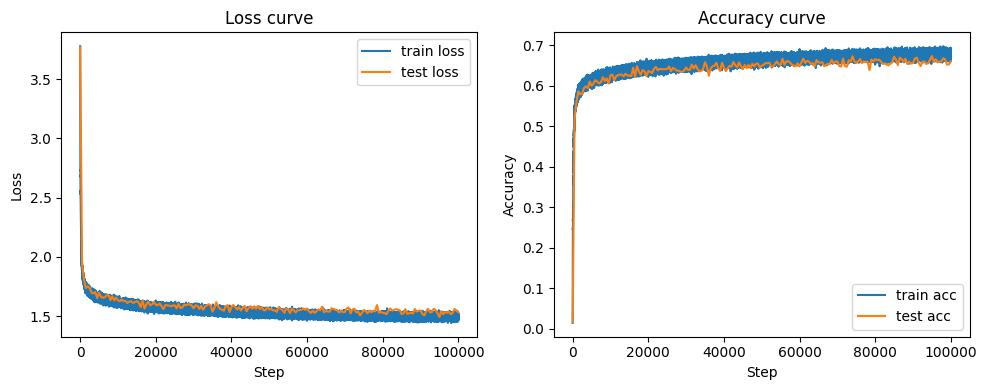

In [10]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(loss_history, label='train loss')
plt.plot(np.linspace(0, niter, len(test_loss_history)), test_loss_history, label='test loss')
plt.xlabel("Step")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss curve")

plt.subplot(1,2,2)
plt.plot(acc_history, label='train acc')
plt.plot(np.linspace(0, niter, len(test_acc_history)), test_acc_history, label='test acc')
plt.xlabel("Step")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy curve")
plt.tight_layout()
plt.show()

# Autoregressive text generation

In [11]:
prompt = "hello my fri"
prompt_int = jnp.array([[char_to_int.get(c, len(char_set)) for c in prompt.lower()[:CONFIG["context_length"]]]], dtype=jnp.int32)
gen_len = 1000
rng = jax.random.PRNGKey(42)
out_ids = generation.generate_tokens(model, params, rng, prompt_int, gen_len, block_size=CONFIG["context_length"], temperature=0.5, sample=True)
generated_text = ''.join(int_to_char.get(int(x), '?') for x in list(out_ids[0]))
print(prompt + generated_text)

hello my friend and in a series of international production programs which are called the open source of the general public performance series the first world war the encyclopedia of the country s influence on the international court of justice and the international court of judicial pressure in the one nine two zero s and one nine three zero s and one nine three zero s there were also a business structure in the world in the united states and in xii and a notable invasion of the islands the one nine hundred years after his death in one nine six two and was a national film studio the film was seriously released in one nine seven three and the san francisco four zero seven march one nine seven six eight three five one nine eight six constitution one nine eight six france became the final constitution of one nine eight four the democratic republic of the congo the constitution of labour s party the council of the united states constitution was formed the republican party in the one nine 